# 기본 설정

In [7]:
import re
import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from datasets import (
    Dataset,
    load_from_disk,
    concatenate_datasets,
)
from transformers import AutoConfig, AutoModelForQuestionAnswering, AutoTokenizer
from pprint import pprint
import matplotlib.pyplot as plt
from konlpy.tag import Mecab
from collections import Counter

In [8]:
mecab = Mecab()
print(mecab.morphs("아버지가방에들어가신다"))
print(mecab.pos("아버지가방에들어가신다"))

['아버지', '가', '방', '에', '들어가', '신다']
[('아버지', 'NNG'), ('가', 'JKS'), ('방', 'NNG'), ('에', 'JKB'), ('들어가', 'VV'), ('신다', 'EP+EC')]


In [9]:
wiki_df = pd.read_json("../../data/wikipedia_documents.json")
wiki_df

,0,1,2,3,4,5,6,7,8,9,...,60603,60604,60605,60606,60607,60608,60609,60610,60611,60612
text,"이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개...",이 목록에 실린 국가 기준은 1933년 몬테비데오 협약 1장을 참고로 하였다. 협정...,현 서울특별시 종로구 서린동 (구 일제 강점기 경기도 경성부 서린정) 출신이다. 친...,"아오조라 문고(靑空文庫, あおぞらぶんこ|아오조라 분고)는 ‘일본어판 구텐베르크 프로...",저자 사망 이후 50년이 지나 저작권이 소멸한 메이지 시대부터 쇼와 시대 초기까지의...,아오조라 문고는 자원봉사로 운영되며 열람 역시 무료이다. 서비스 개시 초반에는 보...,"텍스트 파일을 아오조라 문고에 수록할 때, 텍스트 파일이 갖추어야 할 서식을 '아오...",일본어 표기에 많이 쓰이는 올림문자 (후리가나)는 그대로 올려쓰지 않고 '｜'나 '...,켄 톰슨(Ken Thompson) 등과 함께 최초의 유닉스(Unix) 시스템을 개발...,"주기율표(週期律表, 주기률표, periodic table) 또는 주기표(週期表)는 ...",...,"재래식 전력과 비대칭 전력, 즉 핵까지 갖고 있다한 들, 독자적으로 GPS(GNSS...","소련은 1960년 10월, 알제리를 독립 정부로 최초로 인정해준 나라였다. 소련이 ...","미국 안보 매체, 내셔널 인터레스트지는 한국군이 국방비를 늘렸다고, 비스트 모드(짐...","곰 자체는 페름 지역 숲에 사는 동물이 풍부함을 상징하며, 은색인 이유는 금속, 소...","1967년 소련 통치기 페름 시 의회는 새 문장 공모전을 개최하였으며, 1968년까...","오키나와 현립 박물관·미술관( , Okinawa Prefectural Museum ...","1936년 7월, 오키나와현 교육위원회 부설 향토 박물관(沖縄県教育会附設郷土博物館)...",박물관은 개관 10주년이되는 2017년에 관의 애칭 및 마스코트를 일반인에게 공모했...,단결권 및 단체교섭권 협약(Right to Organise and Collectiv...,이 협약은 부당노동행위 제도를 규율하고 있다. 협약 제1조에서 반노동조합 차별행위로...
corpus_source,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,...,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아
url,TODO,TODO,TODO,TODO,TODO,TODO,TODO,TODO,TODO,TODO,...,None,None,None,None,None,None,None,None,None,None
domain,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
title,나라 목록,나라 목록,백남준,아오조라 문고,아오조라 문고,아오조라 문고,아오조라 문고,아오조라 문고,데니스 리치,주기율표,...,자주국방론,자주국방론,자주국방론,페름의 문장,페름의 문장,오키나와 현립 박물관·미술관,오키나와 현립 박물관·미술관,오키나와 현립 박물관·미술관,단결권 및 단체교섭권 협약,단결권 및 단체교섭권 협약
author,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
html,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
document_id,0,1,2,3,4,5,6,7,8,9,...,60603,60604,60605,60606,60607,60608,60609,60610,60611,60612


In [10]:
wiki_df = wiki_df.T
wiki_df

,text,corpus_source,url,domain,title,author,html,document_id
0,"이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개...",위키피디아,TODO,None,나라 목록,None,None,0
1,이 목록에 실린 국가 기준은 1933년 몬테비데오 협약 1장을 참고로 하였다. 협정...,위키피디아,TODO,None,나라 목록,None,None,1
2,현 서울특별시 종로구 서린동 (구 일제 강점기 경기도 경성부 서린정) 출신이다. 친...,위키피디아,TODO,None,백남준,None,None,2
3,"아오조라 문고(靑空文庫, あおぞらぶんこ|아오조라 분고)는 ‘일본어판 구텐베르크 프로...",위키피디아,TODO,None,아오조라 문고,None,None,3
4,저자 사망 이후 50년이 지나 저작권이 소멸한 메이지 시대부터 쇼와 시대 초기까지의...,위키피디아,TODO,None,아오조라 문고,None,None,4
...,...,...,...,...,...,...,...,...
60608,"오키나와 현립 박물관·미술관( , Okinawa Prefectural Museum ...",위키피디아,None,None,오키나와 현립 박물관·미술관,None,None,60608
60609,"1936년 7월, 오키나와현 교육위원회 부설 향토 박물관(沖縄県教育会附設郷土博物館)...",위키피디아,None,None,오키나와 현립 박물관·미술관,None,None,60609
60610,박물관은 개관 10주년이되는 2017년에 관의 애칭 및 마스코트를 일반인에게 공모했...,위키피디아,None,None,오키나와 현립 박물관·미술관,None,None,60610
60611,단결권 및 단체교섭권 협약(Right to Organise and Collectiv...,위키피디아,None,None,단결권 및 단체교섭권 협약,None,None,60611


In [11]:
datasets = load_from_disk("../../data/train_dataset")
datasets

DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
        num_rows: 3952
    })
    validation: Dataset({
        features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
        num_rows: 240
    })
})

In [12]:
# indices.arrow 파일 생성을 위해서 실행
datasets.save_to_disk("../../preprocessed_data/train_dataset")

In [13]:
train_dataset = datasets["train"]
train_dataset

Dataset({
    features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
    num_rows: 3952
})

In [14]:
train_dataset[0]

{'title': '미국 상원',
 'context': '미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다.\\n\\n미국 부통령이 상원의장이 된다. 각 주당 2명의 상원의원이 선출되어 100명의 상원의원으로 구성되어 있다. 임기는 6년이며, 2년마다 50개주 중 1/3씩 상원의원을 새로 선출하여 연방에 보낸다.\\n\\n미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 각종 동의를 하는 기관이다. 하원이 세금과 경제에 대한 권한, 대통령을 포함한 대다수의 공무원을 파면할 권한을 갖고 있는 국민을 대표하는 기관인 반면 상원은 미국의 주를 대표한다. 즉 캘리포니아주, 일리노이주 같이 주 정부와 주 의회를 대표하는 기관이다. 그로 인하여 군대의 파병, 관료의 임명에 대한 동의, 외국 조약에 대한 승인 등 신속을 요하는 권한은 모두 상원에게만 있다. 그리고 하원에 대한 견제 역할(하원의 법안을 거부할 권한 등)을 담당한다. 2년의 임기로 인하여 급진적일 수밖에 없는 하원은 지나치게 급진적인 법안을 만들기 쉽다. 대표적인 예로 건강보험 개혁 당시 하원이 미국 연방 행정부에게 퍼블릭 옵션(공공건강보험기관)의 조항이 있는 반면 상원의 경우 하원안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비영리건강보험기관이나 보험회사가 담당하도록 한 것이다. 이 경우처럼 상원은 하원이나 내각책임제가 빠지기 쉬운 국가들의 국회처럼 걸핏하면 발생하는 의회의 비정상적인 사태를 방지하는 기관이다. 상원은 급박한 처리사항의 경우가 아니면 법안을 먼저 내는 경우가 드물고 하원이 만든 법안을 수정하여 다시 하원에 되돌려보낸다. 이러한 방식으로 단원제가 빠지기 쉬운 함정을 미리 방지하는 것이다.날짜=2017-02-05',
 'question': '대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?',
 'id': 'mrc-1-000067',
 'answers': {'answer_start'

In [15]:
validation_dataset = datasets["validation"]
validation_dataset

Dataset({
    features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
    num_rows: 240
})

In [17]:
test_dataset = load_from_disk("../../data/test_dataset")
test_dataset

DatasetDict({
    validation: Dataset({
        features: ['id', 'question'],
        num_rows: 600
    })
})

In [18]:
test_dataset["validation"][0]

{'question': "유령'은 어느 행성에서 지구로 왔는가?", 'id': 'mrc-1-000653'}

In [19]:
train_validation_dataset = concatenate_datasets([train_dataset, validation_dataset])
train_validation_dataset

Dataset({
    features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
    num_rows: 4192
})

In [20]:
train_validation_answers = train_validation_dataset["answers"]
train_validation_answers[:10]

[{'answer_start': [235], 'text': ['하원']},
 {'answer_start': [212], 'text': ['《경영의 실제》']},
 {'answer_start': [510], 'text': ['백성']},
 {'answer_start': [625], 'text': ['중국']},
 {'answer_start': [30], 'text': ['4개']},
 {'answer_start': [91], 'text': ['드래곤']},
 {'answer_start': [68], 'text': ['형양태수 왕식']},
 {'answer_start': [583], 'text': ['이탈리아군']},
 {'answer_start': [195], 'text': ['큰아들 유']},
 {'answer_start': [861], 'text': ['왕대마을']}]

In [21]:
train_validation_contexts = train_validation_dataset["context"]
train_validation_contexts[:3]

['미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다.\\n\\n미국 부통령이 상원의장이 된다. 각 주당 2명의 상원의원이 선출되어 100명의 상원의원으로 구성되어 있다. 임기는 6년이며, 2년마다 50개주 중 1/3씩 상원의원을 새로 선출하여 연방에 보낸다.\\n\\n미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 각종 동의를 하는 기관이다. 하원이 세금과 경제에 대한 권한, 대통령을 포함한 대다수의 공무원을 파면할 권한을 갖고 있는 국민을 대표하는 기관인 반면 상원은 미국의 주를 대표한다. 즉 캘리포니아주, 일리노이주 같이 주 정부와 주 의회를 대표하는 기관이다. 그로 인하여 군대의 파병, 관료의 임명에 대한 동의, 외국 조약에 대한 승인 등 신속을 요하는 권한은 모두 상원에게만 있다. 그리고 하원에 대한 견제 역할(하원의 법안을 거부할 권한 등)을 담당한다. 2년의 임기로 인하여 급진적일 수밖에 없는 하원은 지나치게 급진적인 법안을 만들기 쉽다. 대표적인 예로 건강보험 개혁 당시 하원이 미국 연방 행정부에게 퍼블릭 옵션(공공건강보험기관)의 조항이 있는 반면 상원의 경우 하원안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비영리건강보험기관이나 보험회사가 담당하도록 한 것이다. 이 경우처럼 상원은 하원이나 내각책임제가 빠지기 쉬운 국가들의 국회처럼 걸핏하면 발생하는 의회의 비정상적인 사태를 방지하는 기관이다. 상원은 급박한 처리사항의 경우가 아니면 법안을 먼저 내는 경우가 드물고 하원이 만든 법안을 수정하여 다시 하원에 되돌려보낸다. 이러한 방식으로 단원제가 빠지기 쉬운 함정을 미리 방지하는 것이다.날짜=2017-02-05',
 "'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 1950년대이다. 2차 세계대전을 마치고, 6.25전쟁의 시기로 유럽은 전후 재건에 집중하고, 유럽 제국주의의 식민지가 독립하여 아프리카, 아시아, 

In [22]:
train_validation_questions = train_validation_dataset["question"]
train_validation_questions[:10]

['대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?',
 '현대적 인사조직관리의 시발점이 된 책은?',
 '강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?',
 '11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?',
 '명문이 적힌 유물을 구성하는 그릇의 총 개수는?',
 '카드모스의 부하들이 간 곳에는 무엇이 있었는가?',
 '관우를 불태워 죽이려한 사람 누구인가?',
 '참호 속에 무기와 장비를 버리고 도주한 집단은?',
 '제2차 세계 대전에 참전하여 사망한 자식은?',
 '고려 공민왕이 처가 식구들과 아내와 함께 피신처로 삼은 마을은?']

# PreProcessing
## train_validation_answers에서 한글, 숫자, 영어, 일본어, 한자를 제외한 문자는 어떠한 것들이 있는가?

In [23]:
# p = re.compile(r"[^ ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z]")
p = re.compile(r"[^ ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Zぁ-ヾ㑀-龜]")
# p = re.compile(r"[^ ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Zぁ-ゔァ-ヴー々〆〤一-龥]")

train_validation_answers_other_chars = []

for data in train_validation_answers:
    other_chars = p.findall(data["text"][0])
    if other_chars != []:
        train_validation_answers_other_chars.extend(other_chars)

train_validation_answers_other_chars = list(set(train_validation_answers_other_chars))
print(len(train_validation_answers_other_chars))
print(sorted(train_validation_answers_other_chars))

37
['!', '"', '%', "'", '(', ')', '+', ',', '-', '.', '/', ':', '<', '>', '~', '\xad', '°', '·', 'ä', 'ć', '‘', '’', '“', '”', '∧', '≪', '≫', '〈', '〉', '《', '》', '「', '」', '『', '』', '＜', '＞']


## train_validation_contexts에서 제거되는 문자들 확인하기

In [24]:
p = re.compile("[^\sㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Zぁ-ヾ㑀-龜!\"%'()+,\-./:<>~\xad°·äć‘’“”∧≪≫〈〉《》「」『』・＜＞]")

train_validation_contexts_other_chars = []

for data in tqdm(train_validation_contexts):
    other_chars = p.findall(data)
    train_validation_contexts_other_chars.extend(other_chars)

train_validation_contexts_other_chars = list(set(train_validation_contexts_other_chars))
print(len(train_validation_contexts_other_chars))
print(sorted(train_validation_contexts_other_chars))

100%|██████████| 4192/4192 [00:00<00:00, 73023.18it/s]

292
['#', '$', '&', '*', ';', '=', '?', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '±', '²', '´', 'µ', '¹', '¾', 'É', 'Ó', '×', 'Þ', 'ß', 'à', 'á', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'ð', 'ó', 'ö', 'ù', 'ú', 'ü', 'ý', 'ā', 'ă', 'Đ', 'đ', 'ē', 'ğ', 'ī', 'ł', 'œ', 'ū', 'ŭ', 'ơ', 'ư', 'ǫ', 'ɔ', 'ə', 'ɛ', 'ʲ', 'ˈ', 'ː', '́', '΄', 'Α', 'Δ', 'Ε', 'Κ', 'Λ', 'Μ', 'Π', 'Σ', 'Φ', 'ά', 'έ', 'ή', 'ί', 'α', 'β', 'γ', 'δ', 'ε', 'η', 'θ', 'ι', 'κ', 'λ', 'μ', 'ν', 'ξ', 'ο', 'π', 'ρ', 'ς', 'τ', 'υ', 'φ', 'χ', 'ω', 'ό', 'ύ', 'ώ', 'І', 'В', 'Л', 'М', 'Н', 'П', 'Р', 'С', 'Ю', 'а', 'в', 'д', 'е', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'х', 'ц', 'ч', 'ш', 'ы', 'я', 'і', 'ִ', 'ַ', 'ׁ', 'ׇ', 'ח', 'י', 'מ', 'ש', 'إ', 'ا', 'ب', 'ة', 'ت', 'ح', 'ر', 'ز', 'س', 'ش', 'ص', 'ع', 'غ', 'ق', 'ك', 'ل', 'م', 'ه', 'و', 'ي', 'ی', 'क', 'त', 'र', 'ल', 'स', '़', 'ा', 'ि', 'ी', 'ु', 'ত', 'র', 'স', 'া', 'ে', 'ச', 'ஜ', 'ட', 'ந', 'ப', 'ம', 'ய', 'ர', 'ல', 'ழ', 'வ', 'ா', 'ு', 'ோ', '்', 'ა', 'გ', 'დ', 'ე',

## wiki_text에서 제거되는 문자들 확인하기

In [25]:
wiki_text = wiki_df["text"]
wiki_other_chars = []

for data in tqdm(wiki_text):
    other_chars = p.findall(data)
    if other_chars != []:
        wiki_other_chars.extend(other_chars)

wiki_other_chars = list(set(wiki_other_chars))
print(len(wiki_other_chars))
print(sorted(wiki_other_chars))

100%|██████████| 60613/60613 [00:00<00:00, 92352.77it/s]

2415
['#', '$', '&', '*', ';', '=', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '\x7f', '\x95', '¡', '¢', '£', '¥', '§', '¨', '«', '¬', '®', '±', '²', '³', '´', 'µ', '¶', '¹', 'º', '»', '¼', '½', '¾', '¿', 'À', 'Á', 'Â', 'Ã', 'Ä', 'Å', 'Æ', 'Ç', 'È', 'É', 'Ê', 'Í', 'Î', 'Ñ', 'Ó', 'Ô', 'Õ', 'Ö', '×', 'Ø', 'Ú', 'Ü', 'Þ', 'ß', 'à', 'á', 'â', 'ã', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ð', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ö', '÷', 'ø', 'ù', 'ú', 'û', 'ü', 'ý', 'þ', 'ÿ', 'Ā', 'ā', 'ă', 'ą', 'Ĉ', 'ĉ', 'Č', 'č', 'ď', 'Đ', 'đ', 'Ē', 'ē', 'ė', 'ę', 'ě', 'Ĝ', 'ĝ', 'ğ', 'ġ', 'Ħ', 'ħ', 'ĩ', 'ī', 'ĭ', 'į', 'İ', 'ı', 'ĵ', 'Ķ', 'ļ', 'Ľ', 'ľ', 'Ł', 'ł', 'ń', 'ņ', 'ň', 'Ŋ', 'ŋ', 'Ō', 'ō', 'ŏ', 'Ő', 'ő', 'Œ', 'œ', 'Ř', 'ř', 'Ś', 'ś', 'Ŝ', 'ŝ', 'Ş', 'ş', 'Š', 'š', 'Ţ', 'ţ', 'ť', 'ŧ', 'ũ', 'Ū', 'ū', 'ŭ', 'ů', 'ű', 'ų', 'ŵ', 'ŷ', 'ź', 'Ż', 'ż', 'Ž', 'ž', 'Ǝ', 'Ə', 'ƒ', 'Ɵ', 'ơ', 'Ƣ', 'ƣ', 'Ư', 'ư', 'Ƶ', 'ƶ', 'ǂ', 'ǃ', 'ǎ', 'ǐ', 'ǒ', 'ǔ', 'ǘ', 'ǚ', 'ǝ', 'Ǫ', 'ǫ', 'ǰ', 'ǵ', 'ǽ', 'ȃ', 'Ș

In [26]:
test_text = train_validation_contexts[0]
test_text

'미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다.\\n\\n미국 부통령이 상원의장이 된다. 각 주당 2명의 상원의원이 선출되어 100명의 상원의원으로 구성되어 있다. 임기는 6년이며, 2년마다 50개주 중 1/3씩 상원의원을 새로 선출하여 연방에 보낸다.\\n\\n미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 각종 동의를 하는 기관이다. 하원이 세금과 경제에 대한 권한, 대통령을 포함한 대다수의 공무원을 파면할 권한을 갖고 있는 국민을 대표하는 기관인 반면 상원은 미국의 주를 대표한다. 즉 캘리포니아주, 일리노이주 같이 주 정부와 주 의회를 대표하는 기관이다. 그로 인하여 군대의 파병, 관료의 임명에 대한 동의, 외국 조약에 대한 승인 등 신속을 요하는 권한은 모두 상원에게만 있다. 그리고 하원에 대한 견제 역할(하원의 법안을 거부할 권한 등)을 담당한다. 2년의 임기로 인하여 급진적일 수밖에 없는 하원은 지나치게 급진적인 법안을 만들기 쉽다. 대표적인 예로 건강보험 개혁 당시 하원이 미국 연방 행정부에게 퍼블릭 옵션(공공건강보험기관)의 조항이 있는 반면 상원의 경우 하원안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비영리건강보험기관이나 보험회사가 담당하도록 한 것이다. 이 경우처럼 상원은 하원이나 내각책임제가 빠지기 쉬운 국가들의 국회처럼 걸핏하면 발생하는 의회의 비정상적인 사태를 방지하는 기관이다. 상원은 급박한 처리사항의 경우가 아니면 법안을 먼저 내는 경우가 드물고 하원이 만든 법안을 수정하여 다시 하원에 되돌려보낸다. 이러한 방식으로 단원제가 빠지기 쉬운 함정을 미리 방지하는 것이다.날짜=2017-02-05'

In [63]:
p = re.compile(r"[^\sㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Zぁ-ヾ㑀-龜!\"%'()+,\-./:<>~\xad°·äć‘’“”∧≪≫〈〉《》「」『』・＜＞]")

preprocessed_test_text = test_text

preprocessed_test_text = re.sub(r"text=", " ", preprocessed_test_text)
preprocessed_test_text = re.sub(r"\n", " ", preprocessed_test_text)
preprocessed_test_text = re.sub(r"\\n", " ", preprocessed_test_text)
preprocessed_test_text = re.sub(p, " ", preprocessed_test_text)
preprocessed_test_text = re.sub(r"\s+", " ", preprocessed_test_text)

preprocessed_test_text

'미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다. 미국 부통령이 상원의장이 된다. 각 주당 2명의 상원의원이 선출되어 100명의 상원의원으로 구성되어 있다. 임기는 6년이며, 2년마다 50개주 중 1/3씩 상원의원을 새로 선출하여 연방에 보낸다. 미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 각종 동의를 하는 기관이다. 하원이 세금과 경제에 대한 권한, 대통령을 포함한 대다수의 공무원을 파면할 권한을 갖고 있는 국민을 대표하는 기관인 반면 상원은 미국의 주를 대표한다. 즉 캘리포니아주, 일리노이주 같이 주 정부와 주 의회를 대표하는 기관이다. 그로 인하여 군대의 파병, 관료의 임명에 대한 동의, 외국 조약에 대한 승인 등 신속을 요하는 권한은 모두 상원에게만 있다. 그리고 하원에 대한 견제 역할(하원의 법안을 거부할 권한 등)을 담당한다. 2년의 임기로 인하여 급진적일 수밖에 없는 하원은 지나치게 급진적인 법안을 만들기 쉽다. 대표적인 예로 건강보험 개혁 당시 하원이 미국 연방 행정부에게 퍼블릭 옵션(공공건강보험기관)의 조항이 있는 반면 상원의 경우 하원안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비영리건강보험기관이나 보험회사가 담당하도록 한 것이다. 이 경우처럼 상원은 하원이나 내각책임제가 빠지기 쉬운 국가들의 국회처럼 걸핏하면 발생하는 의회의 비정상적인 사태를 방지하는 기관이다. 상원은 급박한 처리사항의 경우가 아니면 법안을 먼저 내는 경우가 드물고 하원이 만든 법안을 수정하여 다시 하원에 되돌려보낸다. 이러한 방식으로 단원제가 빠지기 쉬운 함정을 미리 방지하는 것이다.날짜 2017-02-05'

## train_contexts 전처리하기

In [28]:
rows = []
for data in datasets["train"]:
    row = {key: data[key] for key in data.keys()}
    rows.append(row)

train_df = pd.DataFrame(rows)
train_df

,title,context,question,id,answers,document_id,__index_level_0__
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,"{'answer_start': [235], 'text': ['하원']}",18293,42
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,"{'answer_start': [212], 'text': ['《경영의 실제》']}",51638,2873
2,강희제,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,mrc-1-000362,"{'answer_start': [510], 'text': ['백성']}",5028,230
3,금동삼존불감,"불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...",11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,mrc-0-001510,"{'answer_start': [625], 'text': ['중국']}",34146,992
4,계사명 사리구,동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,mrc-0-000823,"{'answer_start': [30], 'text': ['4개']}",47334,548
...,...,...,...,...,...,...,...
3947,이오 (위성),이오의 산\n이오의 산 목록\n 이오에는 100~150개의 산이 있다. 이들 산의 ...,대부분의 이오의 산이 형성되는데 영향을 끼친 것은?,mrc-0-005285,"{'answer_start': [317], 'text': ['지질 구조']}",8275,3445
3948,내니 다이어리,애니의 고군분투 뉴욕 입성기!!\n\n인류학자가 꿈인 21살 소녀 '애니(스칼렛 요...,애니는 어디서 태어났는가?,mrc-1-000699,"{'answer_start': [616], 'text': ['뉴저지']}",37764,450
3949,빈 필하모니 관현악단,1842년에 작곡가이자 지휘자인 오토 니콜라이가 빈 궁정 오페라극장 소속 관현악단을...,1854년에 니콜라이의 뒤를 이어 상임 지휘자로서 활동한 인물은?,mrc-0-003429,"{'answer_start': [255], 'text': ['칼 에케르트']}",12730,2252
3950,드래곤,원어는 고대 그리스어까지 거슬러 올라간다. 영어 문헌에 이 말이 나타나기 시작한 것...,드래곤의 암수 구분이 있는 신화는?,mrc-0-003956,"{'answer_start': [476], 'text': ['슬라브 신화']}",10924,2595


In [29]:
chars_to_remove = [r"text=", r"\n", r"\\n", "[^\sㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Zぁ-ヾ㑀-龜!\"%'()+,\-./:<>~\xad°·äć‘’“”∧≪≫〈〉《》「」『』・＜＞]"]
train_answers = train_df["answers"]
train_contexts = train_df["context"]

for i in tqdm(range(len(train_df))):
    for ctr in chars_to_remove:
        answer_start = train_answers[i]["answer_start"][0]
        shortened_answer_start = answer_start
        for obj in re.finditer(ctr, train_contexts[i]):
            if obj.start() < answer_start:
                 shortened_answer_start -= len(obj.span())
            else:
                break
        train_contexts[i] = re.sub(ctr, "", train_contexts[i])
        train_answers[i]["answer_start"] = [shortened_answer_start]

train_df

  0%|          | 0/3952 [00:00<?, ?it/s]<ipython-input-29-a61da95ca9b6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_contexts[i] = re.sub(ctr, "", train_contexts[i])
100%|██████████| 3952/3952 [00:02<00:00, 1882.20it/s]


,title,context,question,id,answers,document_id,__index_level_0__
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,"{'answer_start': [227], 'text': ['하원']}",18293,42
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,"{'answer_start': [212], 'text': ['《경영의 실제》']}",51638,2873
2,강희제,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,mrc-1-000362,"{'answer_start': [500], 'text': ['백성']}",5028,230
3,금동삼존불감,"불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...",11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,mrc-0-001510,"{'answer_start': [613], 'text': ['중국']}",34146,992
4,계사명 사리구,동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,mrc-0-000823,"{'answer_start': [30], 'text': ['4개']}",47334,548
...,...,...,...,...,...,...,...
3947,이오 (위성),이오의 산이오의 산 목록 이오에는 100~150개의 산이 있다. 이들 산의 평균 높...,대부분의 이오의 산이 형성되는데 영향을 끼친 것은?,mrc-0-005285,"{'answer_start': [307], 'text': ['지질 구조']}",8275,3445
3948,내니 다이어리,애니의 고군분투 뉴욕 입성기!!인류학자가 꿈인 21살 소녀 '애니(스칼렛 요한슨 분...,애니는 어디서 태어났는가?,mrc-1-000699,"{'answer_start': [604], 'text': ['뉴저지']}",37764,450
3949,빈 필하모니 관현악단,1842년에 작곡가이자 지휘자인 오토 니콜라이가 빈 궁정 오페라극장 소속 관현악단을...,1854년에 니콜라이의 뒤를 이어 상임 지휘자로서 활동한 인물은?,mrc-0-003429,"{'answer_start': [251], 'text': ['칼 에케르트']}",12730,2252
3950,드래곤,원어는 고대 그리스어까지 거슬러 올라간다. 영어 문헌에 이 말이 나타나기 시작한 것...,드래곤의 암수 구분이 있는 신화는?,mrc-0-003956,"{'answer_start': [436], 'text': ['슬라브 신화']}",10924,2595


In [30]:
datasets["train"] = Dataset.from_pandas(train_df)
datasets["train"]

Dataset({
    features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
    num_rows: 3952
})

## validation_contexts 전처리하기

In [31]:
rows = []
for data in datasets["validation"]:
    row = {key: data[key] for key in data.keys()}
    rows.append(row)

validation_df = pd.DataFrame(rows)
validation_df

,title,context,question,id,answers,document_id,__index_level_0__
0,전효숙,"순천여자고등학교 졸업, 1973년 이화여자대학교를 졸업하고 1975년 제17회 사법...",처음으로 부실 경영인에 대한 보상 선고를 받은 회사는?,mrc-0-003264,"{'answer_start': [284], 'text': ['한보철강']}",9027,2146
1,스토우빌선,요크 카운티 동쪽에 처음으로 여객 열차 운행이 시작한 시점은 1868년 토론토 & ...,스카버러 남쪽과 코보콘그 마을의 철도 노선이 처음 연장된 연도는?,mrc-0-004762,"{'answer_start': [146], 'text': ['1871년']}",51765,3106
2,촐라,"촐라 정부\n 촐라의 정부 체제는 전제군주제였으며,2001 촐라의 군주는 절대적인 ...",촌락에서 운영 위원 후보자 이름을 쓰기위해 사용된 것은?,mrc-1-001810,"{'answer_start': [517], 'text': ['나뭇잎']}",15694,1180
3,백조 기사,프랑스의 십자군 무훈시는 1099년 예루살렘 왕국의 통치자가 된 고드프루아 드 부용...,로타이르가 백조를 구하기 위해 사용한 것은?,mrc-1-000219,"{'answer_start': [1109], 'text': ['금대야']}",59536,141
4,탈관료제화,탈관료제화는 현대사회에서 관료제 성격이 약화되는 현상이다. 현대사회에서 관료제는 약...,의견을 자유롭게 나누는 것은 조직 내 어떤 관계에서 가능한가?,mrc-1-000285,"{'answer_start': [386], 'text': ['수평적 관계']}",32991,184
...,...,...,...,...,...,...,...
235,전단 (제나라),"연나라 군대의 사령관이 악의에서 기겁으로 교체되자, 전단은 스스로 신령의 계시를 받...",전단이 연나라와의 전쟁에서 승리했을 당시 제나라의 왕은 누구인가?,mrc-0-000484,"{'answer_start': [1084], 'text': ['제 양왕']}",53265,329
236,티칼,현재 우리가 볼 수 있는 티칼의 모습은 펜실베이니아 대학교와 과테말라 정부의 협조 ...,공놀이 경기장 중 일부는 어디에 위치하고 있나?,mrc-0-002095,"{'answer_start': [343], 'text': [''일곱 개의 신전 광장...",12190,1378
237,윤치호,1940년 5월 1일 오전 창씨개명에 비협조적이라는 이유로 조선총독부 경무국에서 소...,창씨개명령의 시행일을 미루는 것을 수락한 인물은?,mrc-0-003083,"{'answer_start': [247], 'text': ['미나미 지로']}",5326,2031
238,신잉카국,빌카밤바 지역은 파차쿠티 황제 때 부터 잉카 제국에 속해있던 지역이었다. 스페인 군...,망코 잉카가 쿠스코를 되찾기 위해 마련한 군사는 총 몇 명인가?,mrc-0-002978,"{'answer_start': [563], 'text': ['200,000명']}",48575,1963


In [32]:
# chars_to_remove = [r"text=", r"\n", r"\\n", "[^\sㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Zぁ-ヾ㑀-龜!\"%'()+,\-./:<>~\xad°·äć‘’“”∧≪≫〈〉《》「」『』・＜＞]"]
validation_answers = validation_df["answers"]
validation_contexts = validation_df["context"]

for i in tqdm(range(len(validation_df))):
    for ctr in chars_to_remove:
        answer_start = validation_answers[i]["answer_start"][0]
        shortened_answer_start = answer_start
        for obj in re.finditer(ctr, validation_contexts[i]):
            if obj.start() < answer_start:
                 shortened_answer_start -= len(obj.span())
            else:
                break
        validation_contexts[i] = re.sub(ctr, "", validation_contexts[i])
        validation_answers[i]["answer_start"] = [shortened_answer_start]

validation_df

  0%|          | 0/240 [00:00<?, ?it/s]<ipython-input-32-3d26349eb663>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_contexts[i] = re.sub(ctr, "", validation_contexts[i])
100%|██████████| 240/240 [00:00<00:00, 2593.57it/s]


,title,context,question,id,answers,document_id,__index_level_0__
0,전효숙,"순천여자고등학교 졸업, 1973년 이화여자대학교를 졸업하고 1975년 제17회 사법...",처음으로 부실 경영인에 대한 보상 선고를 받은 회사는?,mrc-0-003264,"{'answer_start': [280], 'text': ['한보철강']}",9027,2146
1,스토우빌선,요크 카운티 동쪽에 처음으로 여객 열차 운행이 시작한 시점은 1868년 토론토 니...,스카버러 남쪽과 코보콘그 마을의 철도 노선이 처음 연장된 연도는?,mrc-0-004762,"{'answer_start': [144], 'text': ['1871년']}",51765,3106
2,촐라,"촐라 정부 촐라의 정부 체제는 전제군주제였으며,2001 촐라의 군주는 절대적인 권력...",촌락에서 운영 위원 후보자 이름을 쓰기위해 사용된 것은?,mrc-1-001810,"{'answer_start': [507], 'text': ['나뭇잎']}",15694,1180
3,백조 기사,프랑스의 십자군 무훈시는 1099년 예루살렘 왕국의 통치자가 된 고드프루아 드 부용...,로타이르가 백조를 구하기 위해 사용한 것은?,mrc-1-000219,"{'answer_start': [1097], 'text': ['금대야']}",59536,141
4,탈관료제화,탈관료제화는 현대사회에서 관료제 성격이 약화되는 현상이다. 현대사회에서 관료제는 약...,의견을 자유롭게 나누는 것은 조직 내 어떤 관계에서 가능한가?,mrc-1-000285,"{'answer_start': [382], 'text': ['수평적 관계']}",32991,184
...,...,...,...,...,...,...,...
235,전단 (제나라),"연나라 군대의 사령관이 악의에서 기겁으로 교체되자, 전단은 스스로 신령의 계시를 받...",전단이 연나라와의 전쟁에서 승리했을 당시 제나라의 왕은 누구인가?,mrc-0-000484,"{'answer_start': [1072], 'text': ['제 양왕']}",53265,329
236,티칼,현재 우리가 볼 수 있는 티칼의 모습은 펜실베이니아 대학교와 과테말라 정부의 협조 ...,공놀이 경기장 중 일부는 어디에 위치하고 있나?,mrc-0-002095,"{'answer_start': [343], 'text': [''일곱 개의 신전 광장...",12190,1378
237,윤치호,1940년 5월 1일 오전 창씨개명에 비협조적이라는 이유로 조선총독부 경무국에서 소...,창씨개명령의 시행일을 미루는 것을 수락한 인물은?,mrc-0-003083,"{'answer_start': [239], 'text': ['미나미 지로']}",5326,2031
238,신잉카국,빌카밤바 지역은 파차쿠티 황제 때 부터 잉카 제국에 속해있던 지역이었다. 스페인 군...,망코 잉카가 쿠스코를 되찾기 위해 마련한 군사는 총 몇 명인가?,mrc-0-002978,"{'answer_start': [559], 'text': ['200,000명']}",48575,1963


In [33]:
datasets["validation"] = Dataset.from_pandas(validation_df)
datasets["validation"]

Dataset({
    features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
    num_rows: 240
})

In [34]:
datasets.save_to_disk("../../preprocessed_data/train_dataset")

## wiki_text 전처리하기

In [35]:
wiki_text = wiki_df["text"]
wiki_text

0        이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개...
1        이 목록에 실린 국가 기준은 1933년 몬테비데오 협약 1장을 참고로 하였다. 협정...
2        현 서울특별시 종로구 서린동 (구 일제 강점기 경기도 경성부 서린정) 출신이다. 친...
3        아오조라 문고(靑空文庫, あおぞらぶんこ|아오조라 분고)는 ‘일본어판 구텐베르크 프로...
4        저자 사망 이후 50년이 지나 저작권이 소멸한 메이지 시대부터 쇼와 시대 초기까지의...
                               ...                        
60608    오키나와 현립 박물관·미술관( , Okinawa Prefectural Museum ...
60609    1936년 7월, 오키나와현 교육위원회 부설 향토 박물관(沖縄県教育会附設郷土博物館)...
60610    박물관은 개관 10주년이되는 2017년에 관의 애칭 및 마스코트를 일반인에게 공모했...
60611    단결권 및 단체교섭권 협약(Right to Organise and Collectiv...
60612    이 협약은 부당노동행위 제도를 규율하고 있다. 협약 제1조에서 반노동조합 차별행위로...
Name: text, Length: 60613, dtype: object

In [36]:
# chars_to_remove = [r"text=", r"\n", r"\\n", "[^\sㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Zぁ-ヾ㑀-龜!\"%'()+,\-./:<>~\xad°·äć‘’“”∧≪≫〈〉《》「」『』・＜＞]"]

for i in tqdm(range(len(wiki_text)), miniters=10000):
    for ctr in chars_to_remove:
        wiki_text[i] = re.sub(ctr, "", wiki_text[i])

wiki_text

100%|██████████| 60613/60613 [01:55<00:00, 524.21it/s]


0        이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개...
1        이 목록에 실린 국가 기준은 1933년 몬테비데오 협약 1장을 참고로 하였다. 협정...
2        현 서울특별시 종로구 서린동 (구 일제 강점기 경기도 경성부 서린정) 출신이다. 친...
3        아오조라 문고(靑空文庫, あおぞらぶんこ아오조라 분고)는 ‘일본어판 구텐베르크 프로젝...
4        저자 사망 이후 50년이 지나 저작권이 소멸한 메이지 시대부터 쇼와 시대 초기까지의...
                               ...                        
60608    오키나와 현립 박물관·미술관( , Okinawa Prefectural Museum ...
60609    1936년 7월, 오키나와현 교육위원회 부설 향토 박물관(沖縄県教育会附設郷土博物館)...
60610    박물관은 개관 10주년이되는 2017년에 관의 애칭 및 마스코트를 일반인에게 공모했...
60611    단결권 및 단체교섭권 협약(Right to Organise and Collectiv...
60612    이 협약은 부당노동행위 제도를 규율하고 있다. 협약 제1조에서 반노동조합 차별행위로...
Name: text, Length: 60613, dtype: object

In [37]:
wiki_df = wiki_df.T
wiki_df

,0,1,2,3,4,5,6,7,8,9,...,60603,60604,60605,60606,60607,60608,60609,60610,60611,60612
text,"이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개...",이 목록에 실린 국가 기준은 1933년 몬테비데오 협약 1장을 참고로 하였다. 협정...,현 서울특별시 종로구 서린동 (구 일제 강점기 경기도 경성부 서린정) 출신이다. 친...,"아오조라 문고(靑空文庫, あおぞらぶんこ아오조라 분고)는 ‘일본어판 구텐베르크 프로젝...",저자 사망 이후 50년이 지나 저작권이 소멸한 메이지 시대부터 쇼와 시대 초기까지의...,아오조라 문고는 자원봉사로 운영되며 열람 역시 무료이다. 서비스 개시 초반에는 보...,"텍스트 파일을 아오조라 문고에 수록할 때, 텍스트 파일이 갖추어야 할 서식을 '아오...",일본어 표기에 많이 쓰이는 올림문자 (후리가나)는 그대로 올려쓰지 않고 ''나 '《...,켄 톰슨(Ken Thompson) 등과 함께 최초의 유닉스(Unix) 시스템을 개발...,"주기율표(週期律表, 주기률표, periodic table) 또는 주기표(週期表)는 ...",...,"재래식 전력과 비대칭 전력, 즉 핵까지 갖고 있다한 들, 독자적으로 GPS(GNSS...","소련은 1960년 10월, 알제리를 독립 정부로 최초로 인정해준 나라였다. 소련이 ...","미국 안보 매체, 내셔널 인터레스트지는 한국군이 국방비를 늘렸다고, 비스트 모드(짐...","곰 자체는 페름 지역 숲에 사는 동물이 풍부함을 상징하며, 은색인 이유는 금속, 소...","1967년 소련 통치기 페름 시 의회는 새 문장 공모전을 개최하였으며, 1968년까...","오키나와 현립 박물관·미술관( , Okinawa Prefectural Museum ...","1936년 7월, 오키나와현 교육위원회 부설 향토 박물관(沖縄県教育会附設郷土博物館)...",박물관은 개관 10주년이되는 2017년에 관의 애칭 및 마스코트를 일반인에게 공모했...,단결권 및 단체교섭권 협약(Right to Organise and Collectiv...,이 협약은 부당노동행위 제도를 규율하고 있다. 협약 제1조에서 반노동조합 차별행위로...
corpus_source,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,...,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아
url,TODO,TODO,TODO,TODO,TODO,TODO,TODO,TODO,TODO,TODO,...,None,None,None,None,None,None,None,None,None,None
domain,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
title,나라 목록,나라 목록,백남준,아오조라 문고,아오조라 문고,아오조라 문고,아오조라 문고,아오조라 문고,데니스 리치,주기율표,...,자주국방론,자주국방론,자주국방론,페름의 문장,페름의 문장,오키나와 현립 박물관·미술관,오키나와 현립 박물관·미술관,오키나와 현립 박물관·미술관,단결권 및 단체교섭권 협약,단결권 및 단체교섭권 협약
author,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
html,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
document_id,0,1,2,3,4,5,6,7,8,9,...,60603,60604,60605,60606,60607,60608,60609,60610,60611,60612


In [38]:
wiki_df.to_json("../../preprocessed_data/wikipedia_documents.json")

## test_dataset 복사하기

In [39]:
test_dataset = load_from_disk("../../data/test_dataset")
test_dataset.save_to_disk("../../preprocessed_data/test_dataset")

# PostProcessing
## train_answers를 형태소 분석했을때 어떠한 품사 태깅이 있고 끝부분은 주로 무엇인가? J로 시작하는 조사가 정말 없을까?

In [40]:
pumsa_tagging = [mecab.pos(data["text"][0]) for data in train_validation_answers]
print(len(train_validation_answers))
pumsa_tagging[:10]

4192


[[('하원', 'NNG')],
 [('《', 'SY'), ('경영', 'NNG'), ('의', 'JKG'), ('실제', 'NNG'), ('》', 'SY')],
 [('백성', 'NNG')],
 [('중국', 'NNP')],
 [('4', 'SN'), ('개', 'NNBC')],
 [('드래곤', 'NNP')],
 [('형', 'NNG'), ('양태수', 'NNP'), ('왕식', 'NNP')],
 [('이탈리아', 'NNP'), ('군', 'NNG')],
 [('큰', 'VA+ETM'), ('아들', 'NNG'), ('유', 'NNG')],
 [('왕대', 'NNG'), ('마을', 'NNG')]]

In [41]:
start_pumsa_tagging = [pt[0][1] for pt in pumsa_tagging]
end_pumsa_tagging = [pt[-1][1] for pt in pumsa_tagging]
print(Counter(start_pumsa_tagging))
print(Counter(end_pumsa_tagging))

Counter({'NNG': 1745, 'NNP': 1408, 'SN': 581, 'SY': 159, 'MM': 53, 'SL': 44, 'XPN': 39, 'IC': 35, 'MAG': 26, 'VV': 18, 'VA+ETM': 14, 'NR': 14, 'VA': 12, 'VV+ETM': 9, 'SSO': 8, 'NP': 7, 'XR': 6, 'UNKNOWN': 2, 'EP': 2, 'NNB': 2, 'VV+ETN': 1, 'VV+EP+EC': 1, 'NP+JKG': 1, 'VCP+EC': 1, 'NNG+JKO': 1, 'JX': 1, 'VV+EC': 1, 'NP+JKS': 1})
Counter({'NNG': 2106, 'NNP': 932, 'NNBC': 518, 'SY': 162, 'SSC': 116, 'XSN': 84, 'SN': 40, 'SL': 36, 'NNB': 34, 'EC': 30, 'VV+EC': 27, 'JX': 17, 'VCP+EC': 13, 'JKB': 9, 'SF': 5, 'VCP+ETM': 5, 'XSV+EC': 4, 'UNKNOWN': 4, 'IC': 4, 'NR': 4, 'VCP': 4, 'JKS': 3, 'ETN': 3, 'VV+ETM': 3, 'XSA+EC+JX': 2, 'VV+ETN': 2, 'XSV+ETN': 2, 'VA+ETM': 2, 'JKB+JX': 2, 'ETM': 2, 'EP': 2, 'MAG': 2, 'VA+ETN': 1, 'VV+EP+EC': 1, 'NNB+JKB+JX': 1, 'XR': 1, 'JC': 1, 'EP+ETM': 1, 'NNG+JKO': 1, 'XSA+EC': 1, 'XSV': 1, 'VA': 1, 'VV+VCP': 1, 'VV': 1, 'VCP+EF': 1})


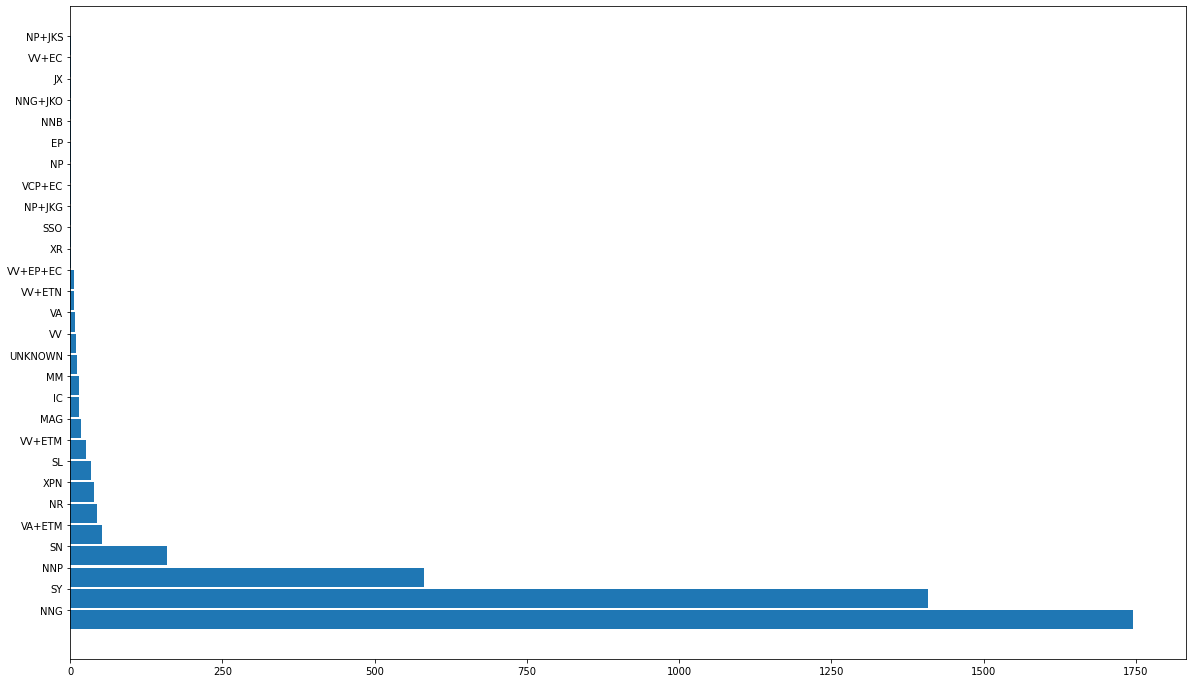

In [42]:
labels, values = zip(*Counter(start_pumsa_tagging).items())

indexes = np.arange(len(labels))
width = 0.9

plt.figure(figsize=(20, 12))
plt.barh(indexes, sorted(values, reverse=True), width, )
plt.yticks(indexes + width * 0.5, labels)
plt.show()

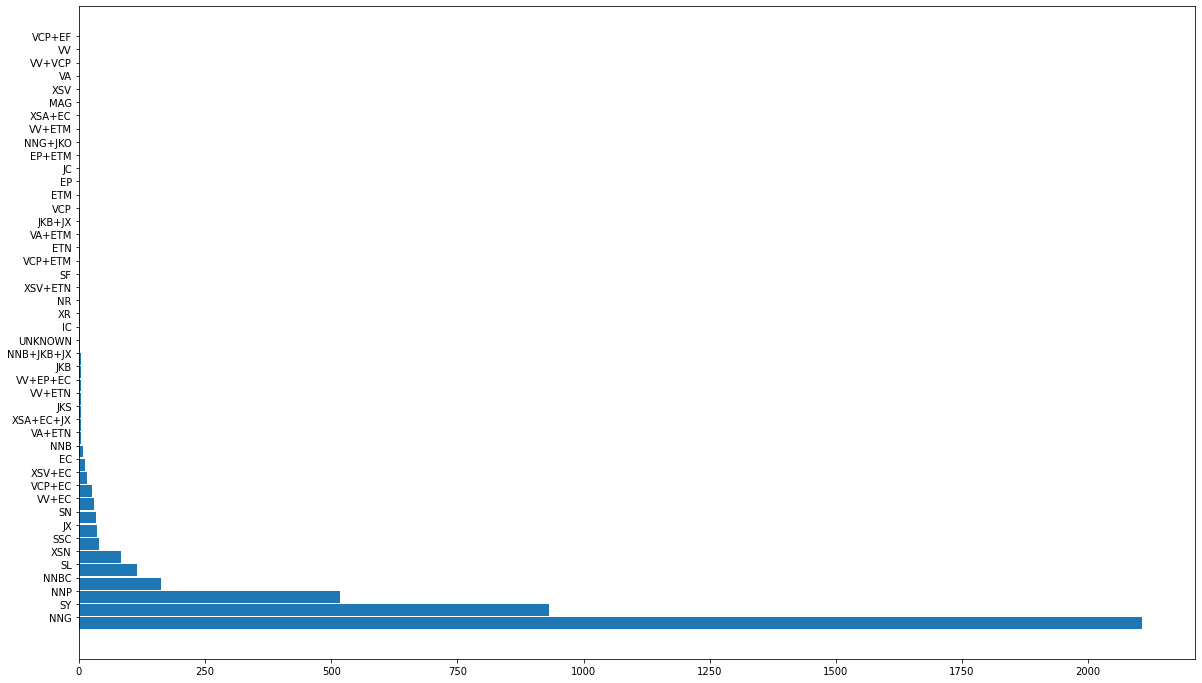

In [43]:
labels, values = zip(*Counter(end_pumsa_tagging).items())

indexes = np.arange(len(labels))
width = 0.9

plt.figure(figsize=(20, 12))
plt.barh(indexes, sorted(values, reverse=True), width, )
plt.yticks(indexes + width * 0.5, labels)
plt.show()

In [44]:
for pt in pumsa_tagging:
    if "J" in pt[-1][1]:
        print(pt)

[('1907', 'SN'), ('년', 'NNBC'), ('까지', 'JX')]
[('예수', 'NNP'), ('그리스', 'NNP'), ('도', 'JX')]
[('트', 'VV'), ('랴', 'EC'), ('피', 'XR'), ('친', 'XSA+EC+JX')]
[('만화', 'NNG'), ('가', 'JKS')]
[('16', 'SN'), ('년', 'NNBC'), ('만', 'JX')]
[('개인', 'NNG'), ('적', 'XSN'), ('인', 'VCP+ETM'), ('차원', 'NNG'), ('의', 'JKG'), ('후원', 'NNG'), ('이', 'VCP'), ('었', 'EP'), ('기', 'ETN'), ('때문', 'NNB'), ('에', 'JKB')]
[('백인', 'NNG'), ('들', 'XSN'), ('은', 'JX'), ('추장', 'NNG'), ('을', 'JKO'), ('‘', 'SY'), ('부족', 'NNG'), ('지배자', 'NNG'), ('’', 'SY'), ('라고', 'JKQ'), ('믿', 'VV'), ('고', 'EC'), ('있', 'VX'), ('기', 'ETN'), ('때문', 'NNB'), ('에', 'JKB')]
[('드레스', 'NNG'), ('덴', 'NNB+JKB+JX')]
[('영산회상', 'NNG'), ('도', 'JX')]
[('마루노우치', 'NNP'), ('선', 'JKB+JX')]
[('1525', 'SN'), ('년', 'NNBC'), ('까지', 'JX')]
[('북위', 'NNG'), ('50', 'SN'), ('도', 'NNBC'), ('이남', 'NNG'), ('의', 'JKG'), ('사할린', 'NNP'), ('섬', 'NNG'), ('및', 'MAJ'), ('조차지', 'NNG'), ('요동', 'NNG'), ('반', 'NNG'), ('도', 'JX')]
[('건강', 'NNG'), ('질', 'XSN'), ('의서', 'JKB')]
[('스', 'VV'), ('

In [45]:
SY = []
for pt in pumsa_tagging:
    for p in pt:
        if p[1] == "SY":
            SY.append(p[0])
print(set(SY))

{'〈', '!', '≪', '『', '>', '~', '°', '%', '’(', '’', "'", '》', '-', '〉', '.', "'(", '＞', '\xad', '≫', '＜', '"(', '〉(', '』', '》(', '‘', '..', '+', '‘∧’', '《', '<', '"'}


# Question과 Context쌍 사이의 겹치는 토큰 비율 분석

In [46]:
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

In [47]:
train_validation_same_tokens_ratio = []
for idx, train_validation_question in enumerate(tqdm(train_validation_questions)):
    train_validation_same_tokens = 0
    train_validation_question_tokens = tokenizer.tokenize(train_validation_question)
    for token in train_validation_question_tokens:
        if token in tokenizer.tokenize(train_validation_contexts[idx]):
            train_validation_same_tokens += 1

    train_validation_same_tokens_ratio.append(train_validation_same_tokens / len(train_validation_question_tokens))

np.mean(train_validation_same_tokens_ratio)


100%|██████████| 4192/4192 [01:45<00:00, 39.80it/s]


0.7046292660281174

(array([   2.,    2.,   15.,   61.,  273.,  771., 1229., 1265.,  501.,
          73.]),
 array([0.1 , 0.19, 0.28, 0.37, 0.46, 0.55, 0.64, 0.73, 0.82, 0.91, 1.  ]),
 <BarContainer object of 10 artists>)

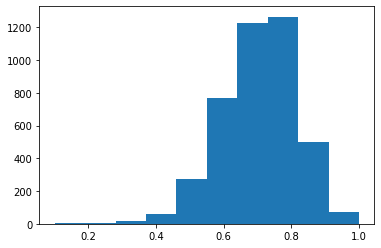

In [48]:
plt.hist(train_validation_same_tokens_ratio)

## etc.

In [51]:
for va in validation_answers:
    print(va)

{'answer_start': [280], 'text': ['한보철강']}
{'answer_start': [144], 'text': ['1871년']}
{'answer_start': [507], 'text': ['나뭇잎']}
{'answer_start': [1097], 'text': ['금대야']}
{'answer_start': [382], 'text': ['수평적 관계']}
{'answer_start': [404], 'text': ['옥음방송']}
{'answer_start': [192], 'text': ['코칭 스티치']}
{'answer_start': [31], 'text': ['복잡한 감염병']}
{'answer_start': [613], 'text': ['스페인']}
{'answer_start': [71], 'text': ['20세기 초']}
{'answer_start': [274], 'text': ['"5월의 왕"']}
{'answer_start': [897], 'text': ["'일급 비밀 프로젝트 2501'"]}
{'answer_start': [426], 'text': ['테헤란']}
{'answer_start': [315], 'text': ['역사교육과정개발추진위원회']}
{'answer_start': [1401], 'text': ['1967년 11월 15일']}
{'answer_start': [0], 'text': ['1965년']}
{'answer_start': [156], 'text': ['아리크 부케']}
{'answer_start': [695], 'text': ['〈중앙일보〉']}
{'answer_start': [296], 'text': ['미타케성']}
{'answer_start': [532], 'text': ['전체 4순위']}
{'answer_start': [677], 'text': ['뇌물']}
{'answer_start': [78], 'text': ['보통 유형 준융합성 천연두']}
{'answer_start': [362], 